# Hierarchical Clustering
Clustering algorithm that sound a lot like a union-find algorithm study case.

This is inspired by [StatQuest: Hierarchical Clustering](https://youtu.be/7xHsRkOdVwo)

## Setup

In [386]:
import math
import einops
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from collections import Counter

%matplotlib inline

## Fake data

In [387]:
torch.manual_seed(0xba11ad)

n_clusters = 6
n_samples = 250
clusters = []
centroids = torch.rand(n_clusters, 2) * 100 - 50
for centroid in centroids:
    clusters.append(MultivariateNormal(centroid, torch.diag(torch.tensor([5., 5.]))).sample((n_samples,)))

data = torch.cat(clusters)

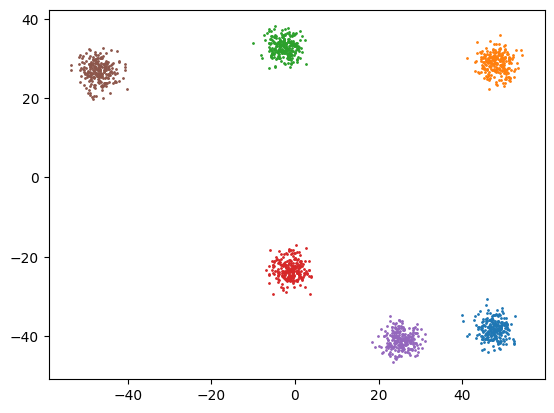

In [388]:
def plot_data(clusters, ax=None):
    if ax is None: _, ax = plt.subplots()
    for cluster in clusters:
        ax.scatter(cluster[:,0], cluster[:,1], s=1)

_ = plot_data(clusters)

## Code
Compute all distances pair, merge the two closest points into a cluster. Rince and repeat.

There's 3 main options to compare a point to a cluster:
- `centroid`: take the average of the cluster
- `single-linkage`: the closest point in each cluster (this seems like the most computationaly efficient to me)
- `complete-linkage`: the furthest point in each cluster (and this one the most inneficient)

There's also options to compute the distance e.g.:
- Euclidean
- Manathan
- Cosine

## Compute all pairwise distances
There are many options, I put a few selection for fun

In [389]:
# generate a fake dataset
d = torch.arange(10).float().reshape(5, 2)**2

# (1) using torch built-in
pd1 = torch.cdist(d, d)

# (2) using einops
m1 = einops.rearrange(d, 'i d -> i 1 d')
m2 = einops.rearrange(d, 'j d -> 1 j d')
pd2 = ((m1 - m2)**2).sum(dim=-1).sqrt()

# (3) using slices
pd3 = torch.norm(d[:, None, :] - d[None, :, :], dim=-1)

assert pd1.allclose(pd2)
assert pd1.allclose(pd3)

## Algo
This would have been the perfect candidate to use union-find instead with path compression. But my goal here was to make a vectorized implementation.

In [390]:
# WARNING: this is horribly slow, the complexity is terrible, and it should use union-find with path compression.
@torch.no_grad()
def hierarchical_clustering(data, n_clusters=6):
    num_samples = data.shape[0]
    distances = torch.cdist(data, data) # pairwise distances
    mask = torch.zeros_like(distances).fill_diagonal_(math.inf) # mask the diagonal (we don't care about distance to self)
    clusters = torch.arange(num_samples) # everything is its own cluster

    for _ in range(num_samples - n_clusters):
        am = (distances + mask).argmin() # find the shortest pair of clusters
        i, j = am // num_samples, am % num_samples # emulate a divmod here

        # mask the merged cluster i
        mask[i] = math.inf
        mask[:, i] = math.inf

        # update the distances, by merging cluster i into j
        # - torch.min() for single-linkage clustering
        # - torch.max() for complete-linkage clustering
        distances[j] = torch.min(distances[i], distances[j])

        # everything that was in cluster i, is now in cluster j
        clusters = torch.where(clusters == clusters[i], clusters[j], clusters)
    return clusters


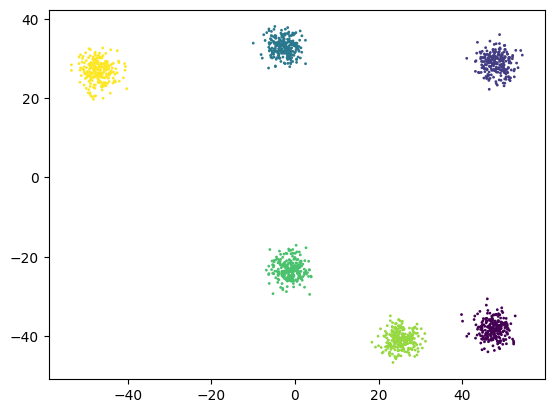

In [391]:
# run on the GPU
data = data.cuda()
clusters = hierarchical_clustering(data)
data = data.cpu()
_ = plt.scatter(data[:, 0], data[:, 1], c=clusters, s=1)

## Animation

### make a smaller dataset

In [392]:
torch.manual_seed(0xba11ad)

n_clusters = 2
n_samples = 20
clusters = []
centroids = torch.rand(n_clusters, 2) * 50 - 25
for centroid in centroids:
    clusters.append(MultivariateNormal(centroid, torch.diag(torch.tensor([10., 10.]))).sample((n_samples,)))

data = torch.cat(clusters)

In [393]:
def hc(data, n_clusters=n_clusters):
    num_samples = data.shape[0]
    distances = torch.cdist(data, data) # pairwise distances
    mask = torch.zeros_like(distances).fill_diagonal_(math.inf) # mask the diagonal (we don't care about distance to self)
    clusters = torch.arange(num_samples) # everything is its own cluster
    all_clusters = [clusters.clone()]

    for _ in range(num_samples - n_clusters):
        am = (distances + mask).argmin() # find the shortest pair of clusters
        i, j = am // num_samples, am % num_samples # emulate a divmod here

        # mask the merged cluster i
        mask[i] = math.inf
        mask[:, i] = math.inf

        # update the distances, by merging cluster i into j
        # - torch.min() for single-linkage clustering
        # - torch.max() for complete-linkage clustering
        distances[j] = torch.min(distances[i], distances[j])

        # everything that was in cluster i, is now in cluster j
        clusters = torch.where(clusters == clusters[i], clusters[j], clusters)
        all_clusters.append(clusters.clone())
    return all_clusters

def f(all_clusters):
    d0, d1 = data[:, 0], data[:, 1]
    def update(frame):
        clusters = all_clusters[frame]
        counts = Counter(clusters.tolist())
        clusters = [c if counts[c] > 1 else -1 for c in clusters.tolist()] # only keep clusters with more than 1 point
        ax.clear()
        ax.scatter(d0, d1, c=clusters)
    return update
     
all_clusters = hc(data)
fig, ax = plt.subplots()
ani = FuncAnimation(fig, f(all_clusters), frames=len(all_clusters), interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())